/Users/vivi/miniconda3/envs/AI/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/30], Loss: 0.28363198041915894
Epoch [2/30], Loss: 0.2512936294078827
Epoch [3/30], Loss: 0.22052335739135742
Epoch [4/30], Loss: 0.19119255244731903
Epoch [5/30], Loss: 0.16324907541275024
Epoch [6/30], Loss: 0.13680283725261688
Epoch [7/30], Loss: 0.11228618770837784
Epoch [8/30], Loss: 0.09054233133792877
Epoch [9/30], Loss: 0.07290796935558319
Epoch [10/30], Loss: 0.061265382915735245
Epoch [11/30], Loss: 0.05776490271091461
Epoch [12/30], Loss: 0.06321094185113907
Epoch [13/30], Loss: 0.07312115281820297
Epoch [14/30], Loss: 0.0796000137925148
Epoch [15/30], Loss: 0.07977595180273056
Epoch [16/30], Loss: 0.0753915011882782
Epoch [17/30], Loss: 0.06931069493293762
Epoch [18/30], Loss: 0.06375525146722794
Epoch [19/30], Loss: 0.059864431619644165
Epoch [20/30], Loss: 0.05786491930484772
Epoch [21/30], Loss: 0.05743599310517311
Epoch [22/30], Loss: 0.058044251054525375
Epoch [23/30], Loss: 0.05916077643632889
Epoch [24/30], Loss: 0.060363683849573135
Epoch [25/30], Loss: 0.0

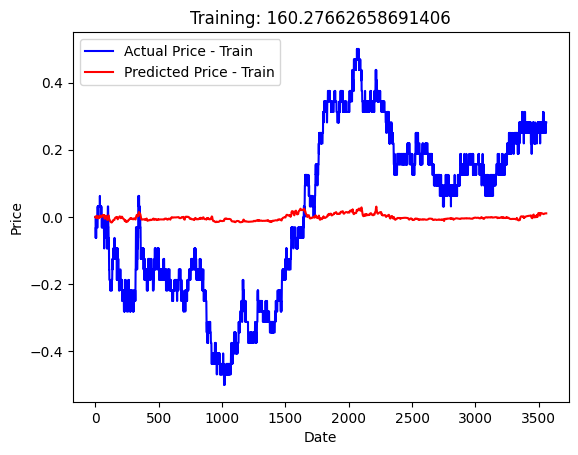

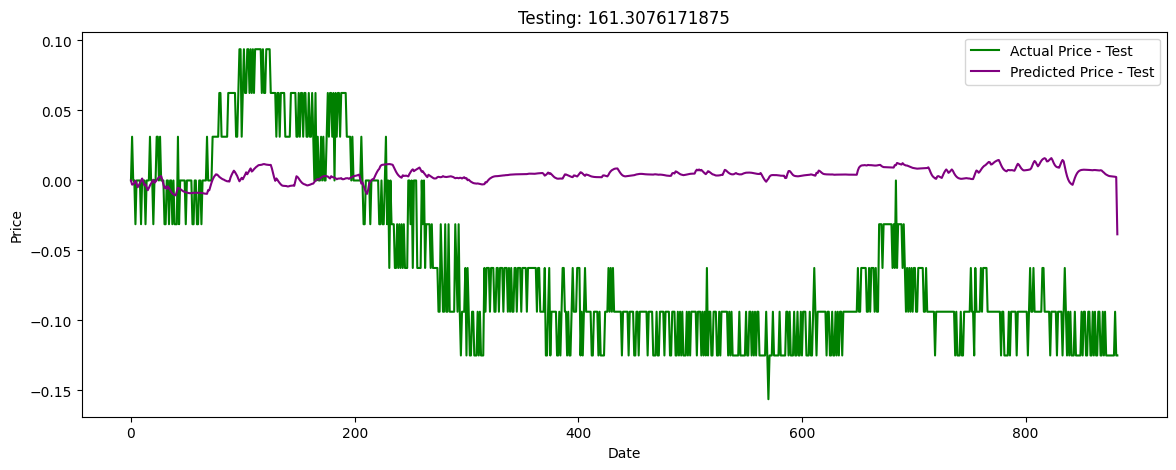

In [2]:
import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# 读取二进制文件内容
file_name = './data/tick_data.csv'
with open(file_name, 'rb') as f:
    result = chardet.detect(f.read())

# 获取检测到的编码格式
encoding = result['encoding']

# 使用检测到的编码格式读取文件
tick_data = pd.read_csv(
    file_name,
    encoding=encoding,
)
tick_data.drop(columns=['市场代码', '证券代码'], inplace=True)
tick_data['时间'] = pd.to_datetime(tick_data['时间'])
tick_data = tick_data.sort_values(by='时间')

features = ['成交笔数','成交额','成交量','买一价', '买二价', '买三价', '买四价',
       '买五价', '卖一价', '卖二价', '卖三价', '卖四价', '卖五价', '买一量', '买二量', '买三量', '买四量',
       '买五量', '卖一量', '卖二量', '卖三量', '卖四量', '卖五量']
# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tick_data[features + ['最新价']].values)

# 创建一个新的scaler用于目标值
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(tick_data[['最新价']].values)

# 在创建数据集时，使用scaled_target替换scaled_data的最后一列
scaled_data[:, -1] = scaled_target.flatten()

# 创建训练和测试数据集
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# 创建数据集函数
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), :-1]  # 取除最后一列之外的所有列为特征
        X.append(a)
        Y.append(data[i + time_step, -1])  # 取最后一列为目标值
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 转换为Tensor
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(1)

# 创建LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 模型参数
input_size = len(features)
hidden_size = 50
num_layers = 2
output_size = 1


model = LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# 预测
model.eval()
train_predict = model(X_train).detach().numpy()
test_predict = model(X_test).detach().numpy()

# 反归一化
# train_predict = target_scaler.inverse_transform(train_predict)
# test_predict = target_scaler.inverse_transform(test_predict)
train_predict = train_predict
test_predict = test_predict
# 计算均方误差
mse_train = mean_squared_error(target_scaler.inverse_transform(y_train.detach().numpy()), train_predict)
mse_test = mean_squared_error(target_scaler.inverse_transform(y_test.detach().numpy()), test_predict)

print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')

plt.plot(y_train - y_train[0], color='blue', label='Actual Price - Train')
plt.plot(train_predict - train_predict[0], color='red', label='Predicted Price - Train')
# 设置x轴的格式为时分

plt.title(f'Training: {mse_train}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 绘制测试数据的预测结果
plt.figure(figsize=(14, 5))
actual_price_test = y_test
plt.plot(actual_price_test - actual_price_test[0], color='green', label='Actual Price - Test')
plt.plot(test_predict - test_predict[0], color='purple', label='Predicted Price - Test')
# 设置x轴的格式为时分


plt.title(f'Testing: {mse_test}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [3]:
import chardet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# 读取二进制文件内容
file_name = './data/tick_data.csv'
with open(file_name, 'rb') as f:
    result = chardet.detect(f.read())

# 获取检测到的编码格式
encoding = result['encoding']

# 使用检测到的编码格式读取文件
tick_data = pd.read_csv(
    file_name,
    encoding=encoding,
)
tick_data.drop(columns=['市场代码', '证券代码'], inplace=True)
tick_data['时间'] = pd.to_datetime(tick_data['时间'])
tick_data = tick_data.sort_values(by='时间')

features = ['成交笔数','成交额','成交量','买一价', '买二价', '买三价', '买四价',
       '买五价', '卖一价', '卖二价', '卖三价', '卖四价', '卖五价', '买一量', '买二量', '买三量', '买四量',
       '买五量', '卖一量', '卖二量', '卖三量', '卖四量', '卖五量']
# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tick_data[features + ['最新价']].values)

# 创建一个新的scaler用于目标值
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(tick_data[['最新价']].values)

# 在创建数据集时，使用scaled_target替换scaled_data的最后一列
scaled_data[:, -1] = scaled_target.flatten()

# 创建训练和测试数据集
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# 创建数据集函数
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), :-1]  # 取除最后一列之外的所有列为特征
        X.append(a)
        Y.append(data[i + time_step, -1])  # 取最后一列为目标值
    return np.array(X), np.array(Y)

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# 转换为Tensor
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().unsqueeze(1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().unsqueeze(1)

class CNN_LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(CNN_LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.conv1 = nn.Conv1d(input_size, input_size, kernel_size=5, padding=1)  # 1D convolution
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # change to (batch, channel, time_step)
        x = self.conv1(x)
        x = x.permute(0, 2, 1)  # change back to (batch, time_step, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
# 模型参数
input_size = len(features)
hidden_size = 50
num_layers = 2
output_size = 1


model = CNN_LSTMModel(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# 预测
model.eval()
train_predict = model(X_train).detach().numpy()
test_predict = model(X_test).detach().numpy()

# 反归一化
# train_predict = target_scaler.inverse_transform(train_predict)
# test_predict = target_scaler.inverse_transform(test_predict)
train_predict = train_predict
test_predict = test_predict
# 计算均方误差
mse_train = mean_squared_error(target_scaler.inverse_transform(y_train.detach().numpy()), train_predict)
mse_test = mean_squared_error(target_scaler.inverse_transform(y_test.detach().numpy()), test_predict)

print(f'Train MSE: {mse_train}')
print(f'Test MSE: {mse_test}')

plt.plot(y_train - y_train[0], color='blue', label='Actual Price - Train')
plt.plot(train_predict - train_predict[0], color='red', label='Predicted Price - Train')
# 设置x轴的格式为时分

plt.title(f'Training: {mse_train}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 绘制测试数据的预测结果
plt.figure(figsize=(14, 5))
actual_price_test = y_test
plt.plot(actual_price_test - actual_price_test[0], color='green', label='Actual Price - Test')
plt.plot(test_predict - test_predict[0], color='purple', label='Predicted Price - Test')
# 设置x轴的格式为时分


plt.title(f'Testing: {mse_test}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'tick_data.csv'